In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

input/monkey_labels.txt
input/validation/validation/n6/n603.jpg
input/validation/validation/n6/n614.jpg
input/validation/validation/n6/n6014.jpg
input/validation/validation/n6/n617.jpg
input/validation/validation/n6/n615.jpg
input/validation/validation/n6/n602.jpg
input/validation/validation/n6/n6010.jpg
input/validation/validation/n6/n612.jpg
input/validation/validation/n6/n618.jpg
input/validation/validation/n6/n619.jpg
input/validation/validation/n6/n6013.jpg
input/validation/validation/n6/n613.jpg
input/validation/validation/n6/n600.jpg
input/validation/validation/n6/n604.jpg
input/validation/validation/n6/n608.jpg
input/validation/validation/n6/n616.jpg
input/validation/validation/n6/n609.jpg
input/validation/validation/n6/n606.jpg
input/validation/validation/n6/n607.jpg
input/validation/validation/n6/n6011.jpg
input/validation/validation/n6/n611.jpg
input/validation/validation/n6/n6012.jpg
input/validation/validation/n6/n610.jpg
input/validation/validation/n6/n601.jpg
input/valid

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [3]:
train_dir = "input/training/training"
valid_dir = "input/validation/validation"
label_file = "input/monkey_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
True
True
['n6', 'n0', 'n7', 'n3', 'n8', 'n4', 'n1', 'n5', 'n2', 'n9']
['n6', 'n0', 'n7', 'n3', 'n8', 'n4', 'n1', 'n5', 'n2', 'n9']


In [5]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [6]:
# resnet处理的图像尺寸
height = 224
width = 224
channels = 3
batch_size = 24
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
#     rescale = 1./255, # 归一化
    preprocessing_function=keras.applications.resnet50.preprocess_input, # resnet对图像做的处理，归一化到[-1,1]
    rotation_range = 40, # 图像增强方法
    width_shift_range = 0.2, # 位移，图片位移的鲁棒性，在[0,20%]之间随机选择一个数进行平移
    height_shift_range = 0.2,
    shear_range = 0.2, # 剪切强度
    zoom_range = 0.2, # 缩放强度
    horizontal_flip = True,  # 是否要随机的水平翻转
    fill_mode = 'nearest', # 像素填充规则
)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (height, width),
                                                   batch_size = batch_size,
                                                   seed = 7,
                                                   shuffle = True,
                                                   class_mode = "categorical")
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False, # 不用训练，所以不用混排
                                                    class_mode = "categorical") # label的格式，这里使用onehot编码后的格式
train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [7]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0

In [12]:
resnet50_fine_tune = keras.models.Sequential()
# resnet50针对imagenet训练的，分类个数是1000类，所以要将最后一层去掉include_top=False;
# resnet50倒数第二层的输出是卷积层的输出，是一个三维矩阵而不是一个向量，无法直接连接全连接层，通过加pooling层进行处理
# weights=None,从头开始训练，weights=imagenet,下载imagenet训练好的模型，初始化网络结构
resnet50_fine_tune.add(keras.applications.ResNet50(include_top=False,
                                                  pooling = 'avg',
#                                                   weights = 'imagenet'
#                                                    the path to the weights file to be loaded.
                                                  weights = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'))

# 加全连接层
resnet50_fine_tune.add(keras.layers.Dense(num_classes, activation='softmax'))

# 将resnet这一层trainable设置为False
resnet50_fine_tune.layers[0].trainable = False

# 对于finetune模型来说，sgd是比较好的模型优化器
resnet50_fine_tune.compile(loss="categorical_crossentropy",
                          optimizer='sgd', metrics=['accuracy'])
resnet50_fine_tune.summary()

ValueError: Shapes (1, 1, 256, 512) and (512, 128, 1, 1) are incompatible

In [8]:
epochs = 10
history = resnet50_fine_tune.fit_generator(train_generator,
                             steps_per_epoch = train_num // batch_size,
                             epochs = epochs,
                             validation_data = valid_generator,
                             validation_steps = valid_num // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
17/17 [==============================] - 32s 2s/step - loss: 2.3155 - accuracy: 0.0841 - val_loss: 2.2952 - val_accuracy: 0.1133
Epoch 2/10
17/17 [==============================] - 32s 2s/step - loss: 2.2937 - accuracy: 0.1199 - val_loss: 2.3020 - val_accuracy: 0.1094
Epoch 3/10
17/17 [==============================] - 34s 2s/step - loss: 2.3014 - accuracy: 0.1066 - val_loss: 2.2850 - val_accuracy: 0.1289
Epoch 4/10
17/17 [==============================] - 34s 2s/step - loss: 2.2346 - accuracy: 0.1770 - val_loss: 2.0860 - val_accuracy: 0.1992
Epoch 5/10
17/17 [==============================] - 33s 2s/step - loss: 2.0613 - accuracy: 0.2515 - val_loss: 1.8855 - val_accuracy: 0.3086
Epoch 6/10
17/17 [==============================] - 33s 2s/step - loss: 1.9469 - accuracy: 0.2998 - val_loss: 1.8469 - val_accuracy: 0.2969
Epoch 7/10
17/17 [==============================] - 31s 2s/step - loss: 1.9221 - acc

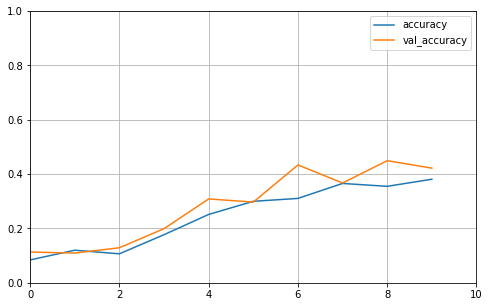

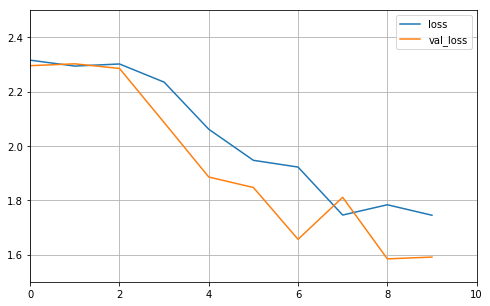

In [17]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_' + label] = history.history['val_' + label]
    pd.DataFrame(data).plot(figsize=(8,5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 1.5, 2.5)
